# Salinity initialization bug

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cm
from xgcm import Grid
from scipy.signal import find_peaks


In [2]:
ave = False ## True means use 5 daily average rather than hourly prog
def open_files():
    if ave:
        prog = xr.open_dataset(base + 'ave_prog.nc')
    else:
        prog = xr.open_dataset(base + 'prog.nc')
    ocean_static = xr.open_dataset(base + "ocean_geometry.nc")
    return prog, ocean_static
def open_IC():
    IC = xr.open_dataset(base + 'MOM_IC.nc')
    return IC
def open_Initialstate():
    IC = xr.open_dataset(base + 'Initial_state.nc')
    return IC


In [3]:
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog, ocean_static = open_files()
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = folder
    label = folder
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


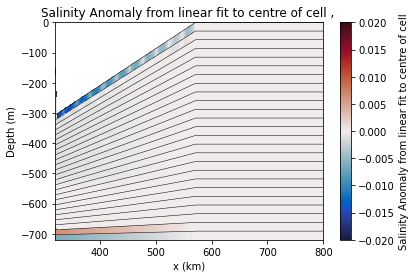

In [4]:
## use IC 

base = ''
folder = ''
fig, ax = plt.subplots()
prog, ocean_static = open_files()
IC = open_IC()
x = -1
time = 0
ymax = 720

# calculate ideal salt from linear fit to centre of cell depth
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8

# plot salinity anomaly
plot(ax,x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell",-0.02,0.02,cm.cm.balance,ymax)


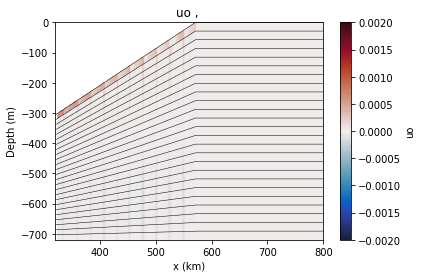

In [7]:
fig, ax = plt.subplots()
plot(ax,x,time,0,prog.u,"uo",-0.002,0.002,cm.cm.balance,ymax)


U spurious velocities have the same frequency as the salt initialization anomaly.